In [1]:
%load_ext autoreload
%autoreload 2

import scipy
import sympy
import pickle
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sympy import Symbol, zeros, Function, MatrixSymbol

# import created modules
from hamiltonian.states import CoupledBasisState
from hamiltonian.generate_hamiltonian import generate_X_hamiltonian_function, generate_B_hamiltonian_function
from hamiltonian.utils import ni_range, matrix_to_states, find_exact_states, reduced_basis_hamiltonian, \
                                find_state_idx_from_state, reorder_evecs

from couplings.utils import ED_ME_mixed_state, collapse_matrices, generate_superoperator, \
                            generate_flat_superoperator, generate_sharp_superoperator
from couplings.generate_coupling import optical_coupling_matrix

from symbolic import generate_density_matrix_symbolic

from utils.plot_utils import set_fontsize
from utils import population, J_levels, J_slice, delete_J_level

In [2]:
script_dir = Path().parent.absolute()

## X-state

Define what states from the $X ^1\Sigma$ electronic state are to be included in the simulation.

In [3]:
#Define what states are to be included in the simulation
Js_g = [0,1,2,3] # J values to be included
I_F = 1/2 #Fluorine nuclear spin
I_Tl = 1/2 #Thallium nuclear spin

#Generate a list of approximate ground states. The exact ground states are determined within the main
#simulation function
ground_states_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                  for J  in Js_g
                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                  for mF in ni_range(-F, F+1)
                 ]

Now generate the J=0 to J=4 Hamiltonian to get the reduced X state Hamiltonian

In [4]:
fname_X = "TlF_X_state_hamiltonian_J0to4.pickle"
fname_transform = "UC_to_C_J0to4.pickle"

path_X = script_dir / "stored_data" / fname_X
path_transform = script_dir / "stored_data" / fname_transform

In [5]:
with open(path_X, 'rb') as f:
    H_X_uc = pickle.load(f)

with open(path_transform, 'rb') as f:
    S_transform = pickle.load(f)

In [6]:
H_X_uc = generate_X_hamiltonian_function(H_X_uc)

# generate coupled basis states
Jmin = 0
Jmax = 4
I_F = 1/2
I_Tl = 1/2

QN_X = [CoupledBasisState(
                F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0
                )
        for J  in ni_range(Jmin, Jmax+1)
        for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
        for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
        for mF in ni_range(-F, F+1)
    ]

E = np.array([0,0,0])
# small magnetic field to ensure m_F is a good quantum number
B = np.array([0,0,0.001])

H_X = S_transform.conj().T @ H_X_uc(E,B) @ S_transform

D, V = np.linalg.eigh(H_X)
V_ref_X = np.eye(V.shape[0])
D, V = reorder_evecs(V,D,V_ref_X)

# diagonalize the Hamiltonian
H_X_diag = V.conj().T @ H_X @ V

# new set of quantum numbers:
QN_X_diag = matrix_to_states(V, QN_X)

In [7]:
ground_states = find_exact_states(ground_states_approx, H_X_diag, QN_X_diag, V_ref = V_ref_X)

H_X_red = reduced_basis_hamiltonian(QN_X_diag, H_X_diag, ground_states)

## B-state
Define what states from the $B ^3\Pi_1$ electronic state are to be included in the simulation. Only need the states that are coupled to J = 1 in the X-state by the laser.

In [8]:
#Define what states are to be included in the simulation

J = 2
F1 = 5/2
F = 2
#Generate a list of excited states. The exact excited states are determined within the main
#simulation function
excited_states_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='B', P = 1, Omega = 1)
                  for mF in ni_range(-F, F+1)
                 ]

Now generate the excited state Hamiltonian to get the reduced B state Hamiltonian

In [9]:
fname_B = "B_hamiltonians_symbolic_coupled_P_1to3.pickle"

path_B = script_dir / "stored_data" / fname_B

In [10]:
with open(path_B, 'rb') as f:
    H_B = pickle.load(f)

In [11]:
H_B = generate_B_hamiltonian_function(H_B)

# generate coupled basis states
Jmin = 0
Jmax = 3
I_F = 1/2
I_Tl = 1/2
Ps = [-1,1]

QN_B = [CoupledBasisState(
                    F,mF,F1,J,I_F,I_Tl,P = P, Omega = 1, electronic_state='B'
                    )
        for J  in ni_range(Jmin, Jmax+1)
        for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
        for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
        for mF in ni_range(-F, F+1)
        for P in Ps
    ]

D,V = np.linalg.eigh(H_B)
V_ref_B = np.eye(H_B.shape[0])
D, V = reorder_evecs(V,D,V_ref_B)

# diagonalize the Hamiltonian
H_B_diag = V.conj().T @ H_B @ V

# new set of quantum numbers:
QN_B_diag = matrix_to_states(V, QN_B)

In [12]:
excited_states = find_exact_states(excited_states_approx, H_B_diag, QN_B_diag, V_ref=V_ref_B)

H_B_red = reduced_basis_hamiltonian(QN_B_diag, H_B_diag, excited_states)

## Total Internal Hamiltonian

In [13]:
H_int = scipy.linalg.block_diag(H_X_red, H_B_red)
H_int[H_int < 0.1] = 0
V_ref_int = np.eye(H_int.shape[0])

#Define Hamiltonian in the rotating frame (transformation not applied yet)
H_rot = H_int.copy()

#Define QN for the total Hamiltonian that includes both X and B
QN = ground_states + excited_states

In [14]:
Γ = 2*np.pi*1.6e6
C_list = collapse_matrices(QN, ground_states, excited_states, gamma = Γ)
C_array = np.array(C_list)
C_conj_array = np.einsum('ijk->ikj', C_array.conj())

 20%|████████████████▊                                                                   | 1/5 [00:00<00:02,  1.35it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.44it/s]


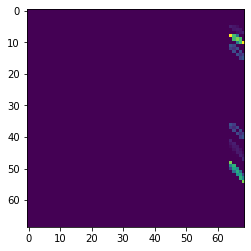

In [23]:
plt.imshow(np.sum(C_list, axis = 0).real)

In [15]:
# generate the superoperator that contains spontaneous decay
# this is constant in time so only generated once
L_collapse = np.zeros((len(QN)**2,len(QN)**2), dtype = complex)
for C in tqdm(C_list):
    L_collapse += (generate_superoperator(C,C.conj().T)
                    -1/2 * (generate_flat_superoperator(C.conj().T @ C) + 
                            generate_sharp_superoperator(C.conj().T @ C)))
#Make the collapse operator into a sparse matrix
L_collapse = csr_matrix(L_collapse)

100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:09<00:00,  9.74it/s]


## Laser coupling

In [ ]:
#Define ground states for laser driven transition
Js = [1]
ground_states_laser_approx =  [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                                  for J  in Js
                                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                                  for mF in ni_range(-F, F+1)
                                 ]

#Define excited states for laser
excited_states_laser_approx = excited_states_approx

In [ ]:
#Define the "main" states. These are used to calculate the detunings and Rabi rates for the transitions
ground_main_approx = 1*CoupledBasisState(J=1,F1=3/2,F=1,mF=1,I1=1/2,I2=1/2,electronic_state='X', P = -1, Omega = 0)
excited_main_approx = 1*CoupledBasisState(J=2,F1=5/2,F=2,mF=1,I1=1/2,I2=1/2, electronic_state='B', P = 1, Omega = 1)

Now generate the laser coupling matrix

In [ ]:
ground_states_laser = find_exact_states(
                                ground_states_laser_approx, H_rot, QN, V_ref = V_ref_int
                                )
excited_states_laser = find_exact_states(
                                excited_states_laser_approx, H_rot, QN, V_ref = V_ref_int
                                )

H_laser_z = optical_coupling_matrix(
                                    QN, 
                                    ground_states_laser, 
                                    excited_states_laser, 
                                    pol_vec = np.array([0,0,1]), 
                                    reduced = False
                                    )
H_laser_x = optical_coupling_matrix(
                                    QN, 
                                    ground_states_laser, 
                                    excited_states_laser, 
                                    pol_vec = np.array([1,0,0]), 
                                    reduced = False
                                    )

In [ ]:
# set small values to zero
H_laser_z[np.abs(H_laser_z) < 1e-3*np.max(np.abs(H_laser_z))] = 0
H_laser_x[np.abs(H_laser_x) < 1e-3*np.max(np.abs(H_laser_x))] = 0

In [ ]:
ground_main = find_exact_states([ground_main_approx], H_rot, QN, V_ref = V_ref_int)[0]
excited_main = find_exact_states([excited_main_approx], H_rot, QN, V_ref = V_ref_int)[0]

ME_main = ED_ME_mixed_state(
                        excited_main, ground_main, pol_vec = np.array([0,0,1])
                        )

ground_main_idx = QN.index(ground_main)
excited_main_idx = QN.index(excited_main)

print(ME_main)
ground_main_approx.print_state()
print('-'*100)
ground_main.print_state()
print('='*100)
excited_main_approx.print_state()
print('-'*100)
excited_main.print_state()

In [ ]:
plt.imshow(H_laser_z.real)

In [ ]:
for s in excited_states:
    s.print_state()
    print("="*100)

## Total Hamiltonian

In [ ]:
# shift energies in H_rot in accordance with the rotating frame
# also shift the energies so that ground_main is at zero energy

Δ = 0
ω_0 = (H_rot[ground_main_idx, ground_main_idx] - H_rot[excited_main_idx, excited_main_idx]).real
ω = ω_0 + Δ

for excited_state in excited_states:
    idx = QN.index(excited_state)
    H_rot[idx, idx] -= ω

H_rot = H_rot  - np.eye(H_rot.shape[0])*H_rot[ground_main_idx,ground_main_idx]

## Collapse Operators

In [ ]:
Γ = 2*np.pi*1.6e6
C_list = collapse_matrices(QN, ground_states, excited_states, gamma = Γ)
C_array = np.array(C_list)
C_conj_array = np.einsum('ijk->ikj', C_array.conj())

In [ ]:
# generate the superoperator that contains spontaneous decay
# this is constant in time so only generated once
L_collapse = np.zeros((len(QN)**2,len(QN)**2), dtype = complex)
for C in tqdm(C_list):
    L_collapse += (generate_superoperator(C,C.conj().T)
                    -1/2 * (generate_flat_superoperator(C.conj().T @ C) + 
                            generate_sharp_superoperator(C.conj().T @ C)))
#Make the collapse operator into a sparse matrix
L_collapse = csr_matrix(L_collapse)

## Converting to symbolic for pre-calculation
Defining constants and functions as symbols

In [ ]:
t = Symbol("t", real = True)
Ω = Symbol("Ω", complex = True)
Ωᶜ = Symbol("Ωᶜ", complex=True) # complex conjuage of Ω
Δ = Symbol("Δ", real = True)

Px = Function("Px")(t) # Polarization switching function for x
Pz = Function("Pz")(t) # Polarization switching function for z

In [ ]:
ρ = generate_density_matrix_symbolic(H_rot.shape[0])

In [ ]:
n_states = H_rot.shape[0]

H_symbolic = zeros(n_states, n_states)
H_symbolic += ((Ω/ME_main)/2)*(H_laser_z*Pz + H_laser_x*Px)

In [ ]:
# ensure Hermitian Hamiltonian for complex Ω
for idx in range(n_states):
    for idy in range(n_states):
        if idx > idy:
            H_symbolic[idx,idy] = H_symbolic[idx,idy].subs(Ω, Ωᶜ)

In [ ]:
for excited_state in excited_states:
    idx = QN.index(excited_state)
    H_symbolic[idx, idx] += Δ

### Doing the matrix calculations
Pretty slow because of the use of symbolic matrices, but in principle only necessary once.  
First part calculates $∑_k 𝐶_𝑘 𝜌𝐶_𝑘^\dagger$

In [ ]:
matrix_mult_sum = zeros(n_states, n_states)
for idx in tqdm(range(C_array.shape[0])):
    matrix_mult_sum[:,:] += C_array[idx]@ρ@C_conj_array[idx]

calculating $[𝐻(𝑡),𝜌]$ and $\frac{1}{2}∑_𝑘(𝐶_𝑘  𝐶_𝑘^\dagger 𝜌+𝜌𝐶_𝑘^\dagger 𝐶_𝑘 ) $

In [ ]:
Cprecalc = np.einsum('ijk,ikl', C_conj_array, C_array)
a = -0.5 * (Cprecalc@ρ + ρ@Cprecalc)
b = -1j*(H_symbolic@ρ - ρ@H_symbolic)

In [ ]:
result = zeros(n_states, n_states)
result += matrix_mult_sum
result += a
result += b

## Convert matrix to system of equations code

In [ ]:
code_lines = []
for idx in tqdm(range(result.shape[0])):
    for idy in range(result.shape[0]):
        if result[idx,idy] != 0:
            cline = str(result[idx,idy])
            cline = f"du[{idx+1},{idy+1}] = " + cline
            cline = cline.replace("Px(t)", "Px")
            cline = cline.replace("Pz(t)", "Pz")
            cline = cline.replace("I", "1im")
            cline += '\n'
            for i in range(result.shape[0]):
                for j in range(result.shape[1]):
                    _ = str(ρ[i,j])
                    cline = cline.replace(_+"*", f"ρ[{i+1},{j+1}]*")
                    cline = cline.replace(_+" ", f"ρ[{i+1},{j+1}] ")
                    cline = cline.replace(_+"\n", f"ρ[{i+1},{j+1}]")
                    cline = cline.replace(_+")", f"ρ[{i+1},{j+1}])")
            cline = cline.strip()
            code_lines.append(cline)

# Solving ODE system with Julia
Need to install Julia and add the following packages to Julia:  
* [DifferentialEquations](https://diffeq.sciml.ai/stable/)
* [Trapz](https://github.com/francescoalemanno/Trapz.jl)

And install [PyJulia](https://pyjulia.readthedocs.io/en/latest/index.html) for python.  

In [ ]:
from julia import Main

In [ ]:
Main.eval("""
using Distributed
using BenchmarkTools
addprocs(6)

@everywhere begin
    using LinearAlgebra
    using Trapz
    using DifferentialEquations
    include("utils/general_ode_functions.jl")
end
""")

## Creating the Julia function to compute the RHS of the Lindblad Equation
Note that only here the polarization switching function is added.  
Anything added symbolically can be modified here.

In [ ]:
ode_fun = """function Lindblad_rhs!(du, ρ, p, t)
\t@inbounds begin
\t\tνp = p[2]
\t\tΔ = p[3]
\t\tΩ = p[1]
\t\tΩᶜ = conj(Ω)
\t\tPx = sine_wave(t, νp, 4.71238898038469)
\t\tPz = sine_wave(t, νp, 1.5707963267948966)
\t\tnorm = sqrt(Px^2+Pz^2)
\t\tPx /= norm
\t\tPz /= norm
"""

In [ ]:
print(ode_fun)

In [ ]:
for cline in code_lines:
    ode_fun += "\t\t"+cline+'\n'
ode_fun += '\t end \n \t nothing \n end'

In [ ]:
with open('ode_fun_R1F2.jl', 'w', encoding='utf8') as f:
    f.write(ode_fun)

In [ ]:
# reading from file
with open('ode_fun_R1F2.jl', 'r', encoding='utf8') as f:
    ode_fun = f.read()

In [ ]:
# making the function in Julia
Main.eval(f"@everywhere {ode_fun}")

### Generate density matrix

In [ ]:
import scipy.constants as cst

def population(J, T, B=6.66733e9, n = 100):
    c = 2*np.pi*cst.hbar*B/(cst.k*T)
    g = lambda J: 4*(2*J+1)
    a = lambda J: -c*J*(J+1)
    Z = np.sum([g(i)*np.exp(a(i)) for i in range(n)])
    return g(J)*np.exp(a(J))/Z

In [ ]:
def J_levels(J):
    return 4*(2*J + 1)

def J_slice(J):
    if J == 0:
        return np.s_[0:J_levels(0)]
    else:
        levels = J_levels(np.arange(J+1))
        return np.s_[np.sum(levels[:-1]):np.sum(levels)]

In [ ]:
T = 6.3
ρ_ini = np.zeros([67,67], dtype = 'complex')

for J in range(0,4):
    p = population(J, T)
    levels = J_levels(J)
    sl = J_slice(J)
    np.fill_diagonal(ρ_ini[sl, sl], p/levels)

ρ_ini /= np.diag(ρ_ini).sum()

In [ ]:
Γ = 2*np.pi*1.6e6
Ω =  1*Γ
ωp = Γ
νp = ωp/(2*np.pi)
Δ = 0
Main.Ω = Ω
Main.ωp = ωp
Main.νp = νp
Main.Δ = Δ
Main.Γ = Γ

Main.ρ_ini = ρ_ini

# setting up the parameters to send to the differential equation
Main.eval("p = [Ω, νp, Δ]")

for par in 'Γ, Ω, Δ, ωp, νp'.split(','):
    try:
        Main.eval(f"@eval @everywhere {par} = ${par}")
    except Exception as e:
        print(par)
        raise e

In [ ]:
%%time
du = np.zeros(ρ_ini.shape, dtype = 'complex')
Main.du = du
Main.eval("""
@btime Lindblad_rhs!(du, ρ_ini, p, 0.)
tmp = 0
""")

### Setting up the ODE problem to solve
`tmp = 0` is just to prevent `Main.eval` from outputting the problem in the notebook.  
The ODEProblem takes a function to solve (`Lindblad_rhs!` in this case), initial conditions `ρ_ini`, a timespan `tspan` an additional arguments for the ODE function, denoted here by `p` 

In [ ]:
Main.eval("""
tspan = (0.0f0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
tmp = 0
""")

In [ ]:
%%time
Main.eval("""
@time sol = solve(prob, Tsit5(), abstol = 1e-8, reltol = 1e-5, dt = 1e-9)
""")

In [ ]:
ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("sol.t")

#Plot populations in different J over time when using the exponentiation method
P0_triplet = np.sum(pop_results[1:4,:], axis = 0)
P0_singlet = np.sum(pop_results[0:1,:], axis = 0)
P2 = np.sum(pop_results[4:24,:], axis = 0)
PB1 = np.sum(pop_results[24:,:], axis = 0)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t_array*1e6, P0_triplet, label = 'X, J = 0, F = 1', lw = 3)
ax.plot(t_array*1e6, P0_singlet, label = 'X, J = 0, F = 0', lw = 3)
ax.plot(t_array*1e6, P2, label = 'X, J = 2', lw = 3)
ax.plot(t_array*1e6, PB1, label = 'B, J = 1', lw = 3)
ax.legend(fontsize = 14)
ax.set_xlabel("Time [μs]")
ax.set_ylabel("Population in state")
set_fontsize(ax, 14)